# Simple Approaches to Multi-Label Classification

This program is modified from https://github.com/nkartik94/Multi-Label-Text-Classification
on 2019/11/18 by Yuen-Hsien Tseng

## 1. EDA: Exploratory Data Analysis

In [1]:
import os, sys, time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

In [3]:
data_path  = "../mlabel_corpora/JokeHumorLevel_OneHot.txt"
train_path = "../mlabel_corpora/JokeHumorLevel_train_OneHot.txt"
test_path  = "../mlabel_corpora/JokeHumorLevel_test_OneHot.txt"

In [4]:
# set global variables: df
df = pd.read_csv(data_path, delimiter="\t")
train = pd.read_csv(train_path, delimiter="\t")
test = pd.read_csv(test_path, delimiter="\t")
print(df.shape, train.shape, test.shape) # same as data_raw.shape in Jupyter

(3365, 9) (1691, 9) (1674, 9)


### 1.1. Checking for missing values

In [5]:
missing_values_check = df.isnull().sum()
print(missing_values_check)

ID            0
Title         0
Content       0
HumorLevel    0
1             0
2             0
3             0
4             0
5             0
dtype: int64


### 1.2. Calculating number of jokes under each label

In [6]:
# Jokes with no label are considered to be clean jokes.
# Creating seperate column in dataframe to identify clean jokes.
# We use axis=1 to count row-wise and axis=0 to count column wise
def print_empty_label(df, s):
    rowSums = df.iloc[:,3:].sum(axis=1)
    #print(rowSums.shape)
    #print(rowSums.head())
    clean_comments_count = (rowSums==0).sum(axis=0)

    print(f"Total number of {s} jokes = ",len(df))
    print(f"Number of clean jokes in {s}= ",clean_comments_count)
    print(f"Number of {s} jokes with labels =",(len(df)-clean_comments_count))
    print()

In [7]:
print_empty_label(df, 'all')
print_empty_label(train, 'all')
print_empty_label(test, 'all')

Total number of all jokes =  3365
Number of clean jokes in all=  0
Number of all jokes with labels = 3365

Total number of all jokes =  1691
Number of clean jokes in all=  0
Number of all jokes with labels = 1691

Total number of all jokes =  1674
Number of clean jokes in all=  0
Number of all jokes with labels = 1674



In [8]:
# set global variables: categories
categories = list(df.columns.values)
print(categories)
categories = categories[4:]
print(categories)

['ID', 'Title', 'Content', 'HumorLevel', '1', '2', '3', '4', '5']
['1', '2', '3', '4', '5']


In [9]:
# Calculating number of jokes in each category
def print_category_count(df, categories):
    counts = []
    for category in categories:
        counts.append((category, df[category].sum()))
    df_stats = pd.DataFrame(counts, columns=['category', 'number of jokes'])
    print(df_stats)
    print()

In [10]:
print_category_count(df, categories)
print_category_count(train, categories)
print_category_count(test, categories)

  category  number of jokes
0        1              363
1        2              867
2        3             1313
3        4              729
4        5               93

  category  number of jokes
0        1               47
1        2              251
2        3              742
3        4              604
4        5               47

  category  number of jokes
0        1              316
1        2              616
2        3              571
3        4              125
4        5               46



In [11]:
def plot_category_count(df, categories):
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))

    ax= sns.barplot(categories, df.iloc[:,3:].sum().values)

    plt.title("Jokes in each category", fontsize=24)
    plt.ylabel('Number of jokes', fontsize=18)
    plt.xlabel('Joke Skill', fontsize=18)

    #adding the text labels
    rects = ax.patches
    #print(rects)
    labels = df.iloc[:,3:].sum().values
    #print(labels)
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

    plt.show()

In [12]:
#plot_category_count(df, categories)

### 1.3. Calculating number of jokes having multiple labels

In [13]:
def plot_multiple_label(mlc_labels, multiLabel_counts):
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))

    ax = sns.barplot(mlc_labels, multiLabel_counts.values)

    plt.title("Jokes having multiple labels ")
    plt.ylabel('Number of jokes', fontsize=18)
    plt.xlabel('Number of labels', fontsize=18)

    #adding the text labels
    rects = ax.patches
    labels = multiLabel_counts.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

    plt.show()

In [14]:
def print_multiple_label(df):
    rowSums = df.iloc[:,4:].sum(axis=1)
    multiLabel_counts = rowSums.value_counts()
    print(multiLabel_counts)
    multiLabel_counts = multiLabel_counts.iloc[:]
    #print(multiLabel_counts.index)
    mlc_labels = ['L'+str(i) for i in multiLabel_counts.index]
    print(mlc_labels)
    
    plot_multiple_label(mlc_labels, multiLabel_counts)
    ##return(mlc_labels, multiLabel_counts)

1    3365
dtype: int64
['L1']


/Users/samm1/anaconda3/envs/WoS/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


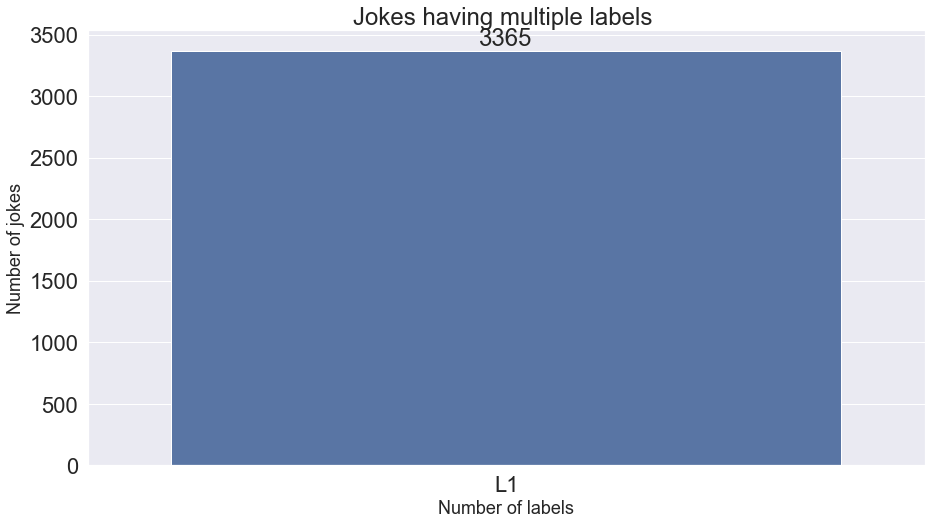

In [15]:
print_multiple_label(df)

### 1.4. WordCloud representation of most used words in each category of jokes

In [16]:
#!pip install wordcloud

In [17]:
from wordcloud import WordCloud, STOPWORDS
import jieba
import Stopwords

In [18]:
plt.figure(figsize=(40,25))

def MyWordCloud(plt, df, field, position):
    #subset = df[df.Pun==1]
    subset = df.loc[df[field] == 1] # https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
    #print(subset.head()); exit
    text = str(subset.Content.values)
    words_list = jieba.lcut(Stopwords.clean_text(text))
    text = Stopwords.clean_words(words_list)
    cloud = WordCloud(
                          #stopwords=STOPWORDS,
                          stopwords=Stopwords.STOP_WORDS,
                          background_color='black',
                          font_path='SNsanafonGyou.ttf', # OSError: unknown file format
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

    plt.subplot(3, 3, position)
    plt.axis('off')
    plt.title(field, fontsize=40)
    plt.imshow(cloud)
    return plt

'''
for i, c in enumerate(categories):
    plt = MyWordCloud(plt, df, c, i+1)

#plt.show()
'''

'\nfor i, c in enumerate(categories):\n    plt = MyWordCloud(plt, df, c, i+1)\n\n#plt.show()\n'

<Figure size 2880x1800 with 0 Axes>

## 2. Data Pre-Processing

In [19]:
# Compute statistics of the dataset: MaxLength, MinLength, AvgChars, AvgWords
Len = df.Content.map(len)
print(f'Number of characters in   all jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')
Len = train.Content.map(len)
print(f'Number of characters in train jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')
Len = test.Content.map(len)
print(f'Number of characters in  test jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')

Number of characters in   all jokes: Max=2024, Min=10, Avg=134.07637444279345
Number of characters in train jokes: Max=2024, Min=10, Avg=132.7906564163217
Number of characters in  test jokes: Max=874, Min=12, Avg=135.3751493428913


In [20]:
# set global variables: data
data = df
#data = df.loc[np.random.choice(df.index, size=3365)]
data.shape

(3365, 9)

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### 2.1. Cleaning Data

In [22]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [23]:
import Stopwords # import my own module with STOP_WORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
ps = PorterStemmer()
wnl = WordNetLemmatizer()

In [24]:
def clean_text(text): 
    '''
    Given a raw text string, return a clean text string.
    Example: 
        input:  "Years  passed. 多少   年过 去 了 。  "
        output: "years passed.多少年过去了。"
    '''
    text = str(text)
    text = text.lower() # 'years  passed. 多少   年过 去 了 。'
    # Next line will remove redundant white space for jeiba to cut
    text = re.sub(r'\s+([^a-zA-Z0-9.])', r'\1', text) # years passed.多少年过去了。
# see: https://stackoverflow.com/questions/16720541/python-string-replace-regular-expression
    text = text.strip(' ')
    return text

def clean_words(text, RmvStopWord=True, RmvMark=True):
    words = jieba.lcut(text)
#    print("After jieba.lcut():", words)
#    WL = [ w 
    WL = [ ps.stem(w)
#    WL = [ wnl.lemmatize(w)
        for w in words 
          if (not re.match(r'\s', w)) # remove white spaces
            and (RmvMark==False or not re.match(r'\W', w)) # remove punctuations
#            and (RmvMark==False or not re.match('^[a-z_]$', w)) # remove punctuations
#            and (RmvMark==False or w not in PUNCTUATIONS)
            and (RmvStopWord==False or w not in Stopwords.STOP_WORDS)
            and (not re.match(r'^\d+$', w)) # remove digit
         ]
    WL = " ".join(WL)
    return WL

In [25]:
print(data.head())
data['Content'] = data['Content'].str.lower()
#data['Content'] = data['Content'].apply(cleanHtml)
#data['Content'] = data['Content'].apply(cleanPunc)
#data['Content'] = data['Content'].apply(keepAlpha)
data['Content'] = data['Content'].apply(clean_text)
data['Content'] = data['Content'].apply(clean_words)
#data.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/lksld56x4_10wxpq687st0x80000gn/T/jieba.cache


      ID Title                                            Content  HumorLevel  \
0  L0001  要求加薪  員工：老闆，您必須幫我加薪，已經有三家公司在找我了！     老闆：哪三家？     員工：...           4   
1  L0002  查無此人  某市政府辦公大樓落成，門口缺副對聯。     副市長揮毫     上聯：說實話辦實事一身正氣...           3   
2  L0003   遣散費  中午老闆視察自己的建築工地時，發現有個人在角落玩手機。     老闆：你月薪多少？     ...           4   
3  L0004  職業習慣  一天，一位法官的女友看見兩個蚊子，便叫法官打死。     只見法官只把那個肚子飽飽的蚊子打死...           2   
4  L0005  美女吵架  辦公室中兩位女同事吵起來了。     經理忍無可忍：「太不像話了！現在是什麼情況？你們把原因...           4   

   1  2  3  4  5  
0  0  0  0  1  0  
1  0  0  1  0  0  
2  0  0  0  1  0  
3  0  1  0  0  0  
4  0  0  0  1  0  


Loading model cost 0.463 seconds.
Prefix dict has been built successfully.


### 2.2. Removing Stop Words

In [26]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['Content'] = data['Content'].apply(removeStopWords)
#data.head()

### 2.3. Stemming

In [27]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

data['Content'] = data['Content'].apply(stemming)
data.head()

,ID,Title,Content,HumorLevel,1,2,3,4,5
0,L0001,要求加薪,員工 老 闆 必須 幫 加薪 已經 三家 公司 找 老 闆 三家 員工 自來 水 公司 台電...,4,0,0,0,1,0
1,L0002,查無此人,某 市政府 辦公大樓 落成 門口 缺 副 對聯 副 市長 揮 毫上 聯 實話 辦實事 一身 ...,3,0,0,1,0,0
2,L0003,遣散費,中午 老 闆 視察 自己 建築 工地 時 發現 個 人 角落 玩手 機 老 闆 月薪 多少 ...,4,0,0,0,1,0
3,L0004,職業習慣,一天 一位 法官 女友 看見 兩個 蚊子 便 叫 法官 打死 只見 法官 只 那個 肚子 飽...,2,0,1,0,0,0
4,L0005,美女吵架,辦 公室 中 兩位 女同事 吵起 經理 忍無可忍 太不像 話 情況 原因 給我 清楚 兩人 ...,4,0,0,0,1,0


### 2.4. Train-Test Split

In [28]:
from sklearn.model_selection import train_test_split

# set global variables: train, test
#train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
train, test = train_test_split(data, random_state=42, train_size=1691, shuffle=False)

print(train.shape)
print(test.shape)

(1691, 9)
(1674, 9)


In [29]:
# set global variables: train_text, test_text
train_text = train['Content']
test_text = test['Content']

In [30]:
# Compute statistics of the dataset: MaxLength, MinLength, AvgChars, AvgWords
Len = data.Content.map(lambda x: len(x.split()))
print(f'Number of words in   all jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')
Len = train.Content.map(lambda x: len(x.split()))
print(f'Number of words in train jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')
Len = test.Content.map(lambda x: len(x.split()))
print(f'Number of words in  test jokes: Max={max(Len)}, Min={min(Len)}, Avg={sum(Len)/len(Len)}')

Number of words in   all jokes: Max=491, Min=3, Avg=41.621991084695395
Number of words in train jokes: Max=491, Min=3, Avg=40.33234772324069
Number of words in  test jokes: Max=290, Min=4, Avg=42.924731182795696


### 2.5. TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
#vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', 
                             ngram_range=(1,2), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['ID', 'Title', 'Content', 'HumorLevel'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['ID', 'Title', 'Content', 'HumorLevel'], axis=1)

In [33]:
time_TfidfVector = time.time()

def Create_TFxIDF(data_text, train_text, test_text):

# word level tf-idf
    #tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
        stop_words=Stopwords.STOP_WORDS, max_df=0.95, min_df=2, max_features=10000)
    tfidf_vect.fit(data_text)
    xtrain_tfidf = tfidf_vect.transform(train_text)
    xtest_tfidf = tfidf_vect.transform(test_text)
    print(f"xtrain_tfidf.shape:{xtrain_tfidf.shape}, xtest_tfidf.shape: {xtest_tfidf.shape}")

# word level ngram tf-idf 
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                    stop_words=Stopwords.STOP_WORDS, max_df=0.95, min_df=2,
                    ngram_range=(2,3), max_features=10000)
    tfidf_vect_ngram.fit(data_text)
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_text)
    xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_text)
    print(f"xtrain_tfidf_ngram.shape:{xtrain_tfidf.shape}, xtest_tfidf_ngram.shape: {xtest_tfidf.shape}")

# character level ngram tf-idf
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', 
                    stop_words=Stopwords.STOP_WORDS, max_df=0.95, min_df=2,
                    ngram_range=(2,3), max_features=10000)
    tfidf_vect_ngram_chars.fit(data_text)
    xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_text) 
    xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_text) 
    print(f"xtrain_tfidf_ngram_chars.shape:{xtrain_tfidf.shape}, xtest_tfidf_ngram_chars.shape: {xtest_tfidf.shape}")

    print("It takes %4.2f seconds to convert 3 TFxIDF vectors."%(time.time()-time_TfidfVector))

    return (xtrain_tfidf, xtest_tfidf, 
             xtrain_tfidf_ngram, xtest_tfidf_ngram,
             xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars,
            tfidf_vect, tfidf_vect_ngram, tfidf_vect_ngram_chars)

(xtrain_tfidf, xtest_tfidf, 
 xtrain_tfidf_ngram, xtest_tfidf_ngram,
 xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars,
 tfidf_vect, tfidf_vect_ngram, tfidf_vect_ngram_chars) = Create_TFxIDF(data.Content, train_text, test_text)

xtrain_tfidf.shape:(1691, 9559), xtest_tfidf.shape: (1674, 9559)
xtrain_tfidf_ngram.shape:(1691, 9559), xtest_tfidf_ngram.shape: (1674, 9559)
xtrain_tfidf_ngram_chars.shape:(1691, 9559), xtest_tfidf_ngram_chars.shape: (1674, 9559)
It takes 1.99 seconds to convert 3 TFxIDF vectors.


In [34]:
# re-assign x_train and x_test to what we want
x_train, x_test, vectorizer = xtrain_tfidf, xtest_tfidf, tfidf_vect
#x_train, x_test, vectorizer = xtrain_tfidf_ngram, xtest_tfidf_ngram, tfidf_vect_ngram
#x_train, x_test, vectorizer = xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars, tfidf_vect_ngram_chars
print(x_train.shape, x_test.shape)
#print(x_train)

(1691, 9559) (1674, 9559)


## 3. Multi-Label Classification

### 3.1. Multiple Binary Classifications - (One Vs Rest Classifier)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [36]:
# define the evaluation metrics
def tcfunc(x, n=4): # trancate a number to have n decimal digits
    d = '0' * n
    d = int('1' + d)
# https://stackoverflow.com/questions/4541155/check-if-a-number-is-int-or-float
    if isinstance(x, (int, float)): return int(x * d) / d
    return x

def print_cls_report(y_true, prediction):
    print('Test accuracy is %1.4f'%(accuracy_score(y_true, prediction)))

    print(classification_report(y_true, prediction))
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    print("\tPrecision\tRecall\tF1\tSupport")
    (Precision, Recall, F1, Support) = list(map(tcfunc, 
        precision_recall_fscore_support(y_true, prediction, average='micro')))
    print("Micro\t{}\t{}\t{}\t{}".format(Precision, Recall, F1, Support))

    (Precision, Recall, F1, Support) = list(map(tcfunc, 
        precision_recall_fscore_support(y_true, prediction, average='macro')))
    print("Macro\t{}\t{}\t{}\t{}".format(Precision, Recall, F1, Support))
    
#    if True:
    if False:
        print(confusion_matrix(y_true, prediction))
        try: 
            print(classification_report(y_true, prediction, digits=4))
        except ValueError:
            print('May be some category has no predicted samples')
        show_confusion_matrix(prediction)


    print(f'y_true.shape={y_true.shape}, prediction.shape={prediction.shape}')
    #print(y_true.head())
    #print(prediction[0:6])

    # https://stackoverflow.com/questions/152580/whats-the-canonical-way-to-check-for-type-in-python
    pred = prediction
    if not isinstance(pred, np.ndarray): pred = prediction.toarray()
    print(type(y_true), type(prediction), type(pred))
    try:
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
        print('macro roc_auc_score is %1.4f'%(roc_auc_score(y_true, pred, average='macro'))) # default average=’macro’
        print('micro roc_auc_score is %1.4f'%(roc_auc_score(y_true, pred, average='micro')))
    except:
        print("roc_auc_score error!!!")
    try:
        fpr, tpr, thresholds = roc_curve(y_true, pred)
        print(f'fpr={fpr}\ntpr={tpr}\nthresholds={thresholds}')
    except:
        print('roc_curve error!!!')

In [37]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

#for category in categories:
for category in categories:
    printmd('**Processing {} jokes...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    prediction = LogReg_pipeline.predict(x_test)
    print_cls_report(test[category], prediction)

**Processing 1 jokes...**

Test accuracy is 0.8112
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1358
           1       0.00      0.00      0.00       316

    accuracy                           0.81      1674
   macro avg       0.41      0.50      0.45      1674
weighted avg       0.66      0.81      0.73      1674

	Precision	Recall	F1	Support
Micro	0.8112	0.8112	0.8112	None
Macro	0.4056	0.5	0.4478	None
y_true.shape=(1674,), prediction.shape=(1674,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5000
micro roc_auc_score is 0.5000
fpr=[0. 1.]
tpr=[0. 1.]
thresholds=[1 0]


**Processing 2 jokes...**

Test accuracy is 0.6320
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1058
           1       0.00      0.00      0.00       616

    accuracy                           0.63      1674
   macro avg       0.32      0.50      0.39      1674
weighted avg       0.40      0.63      0.49      1674

	Precision	Recall	F1	Support
Micro	0.632	0.632	0.632	None
Macro	0.316	0.5	0.3872	None
y_true.shape=(1674,), prediction.shape=(1674,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5000
micro roc_auc_score is 0.5000
fpr=[0. 1.]
tpr=[0. 1.]
thresholds=[1 0]


**Processing 3 jokes...**

Test accuracy is 0.6350
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      1103
           1       0.40      0.15      0.22       571

    accuracy                           0.64      1674
   macro avg       0.54      0.52      0.49      1674
weighted avg       0.58      0.64      0.58      1674

	Precision	Recall	F1	Support
Micro	0.635	0.635	0.635	None
Macro	0.5363	0.5177	0.4898	None
y_true.shape=(1674,), prediction.shape=(1674,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5178
micro roc_auc_score is 0.5178
fpr=[0.         0.11332729 1.        ]
tpr=[0.         0.14886165 1.        ]
thresholds=[2 1 0]


**Processing 4 jokes...**

Test accuracy is 0.8889
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1549
           1       0.12      0.08      0.10       125

    accuracy                           0.89      1674
   macro avg       0.53      0.52      0.52      1674
weighted avg       0.87      0.89      0.88      1674

	Precision	Recall	F1	Support
Micro	0.8888	0.8888	0.8888	None
Macro	0.5256	0.517	0.5189	None
y_true.shape=(1674,), prediction.shape=(1674,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5171
micro roc_auc_score is 0.5171
fpr=[0.         0.04583602 1.        ]
tpr=[0.   0.08 1.  ]
thresholds=[2 1 0]


**Processing 5 jokes...**

Test accuracy is 0.9725
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1628
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1674
   macro avg       0.49      0.50      0.49      1674
weighted avg       0.95      0.97      0.96      1674

	Precision	Recall	F1	Support
Micro	0.9725	0.9725	0.9725	None
Macro	0.4862	0.5	0.493	None
y_true.shape=(1674,), prediction.shape=(1674,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5000
micro roc_auc_score is 0.5000
fpr=[0. 1.]
tpr=[0. 1.]
thresholds=[1 0]
CPU times: user 78.9 ms, sys: 153 ms, total: 232 ms
Wall time: 1.25 s


### 3.2. Multiple Binary Classifications - (Binary Relevance)

In [38]:
# To use binary relevance, run "pip install scikit-multilearn" in advance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
# Next line refers to: http://scikit.ml/tutorial.html
from sklearn.svm import SVC, LinearSVC

In [39]:
%%time

# initialize binary relevance multi-label classifier
#   with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

printmd('**BinaryRelevance with GaussianNB()**')
print_cls_report(y_test, predictions)

**BinaryRelevance with GaussianNB()**

Test accuracy is 0.1266
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       316
           1       0.39      0.05      0.08       616
           2       0.38      0.28      0.32       571
           3       0.09      0.50      0.15       125
           4       0.12      0.02      0.04        46

   micro avg       0.20      0.15      0.17      1674
   macro avg       0.25      0.17      0.12      1674
weighted avg       0.33      0.15      0.15      1674
 samples avg       0.14      0.15      0.14      1674

	Precision	Recall	F1	Support
Micro	0.2039	0.1529	0.1748	None
Macro	0.2452	0.1719	0.1194	None
y_true.shape=(1674, 5), prediction.shape=(1674, 5)
<class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.csc.csc_matrix'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5132
micro roc_auc_score is 0.5019
roc_curve error!!!
CPU times: user 683 ms, sys: 174 ms, total: 856 ms
Wall time: 906 ms


In [40]:
%%time

# Next line refers to: http://scikit.ml/tutorial.html and 
#   http://scikit.ml/api/skmultilearn.problem_transform.br.html
#classifier = BinaryRelevance(classifier=SVC(), require_dense=[False, True]) # 0.5 very bad!
# https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems
classifier = BinaryRelevance(classifier=LinearSVC(class_weight='balanced')) # 0.5314
#classifier = BinaryRelevance(classifier=LinearSVC()) # Test roc_auc_score is 0.5234

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

printmd('**BinaryRelevance with LinearSVC()**')
print_cls_report(y_test, predictions)

**BinaryRelevance with LinearSVC()**

Test accuracy is 0.1505
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       316
           1       0.30      0.04      0.07       616
           2       0.36      0.42      0.39       571
           3       0.07      0.34      0.11       125
           4       0.00      0.00      0.00        46

   micro avg       0.22      0.18      0.20      1674
   macro avg       0.14      0.16      0.11      1674
weighted avg       0.24      0.18      0.16      1674
 samples avg       0.17      0.18      0.17      1674

	Precision	Recall	F1	Support
Micro	0.2162	0.1816	0.1974	None
Macro	0.1446	0.1596	0.1123	None
y_true.shape=(1674, 5), prediction.shape=(1674, 5)
<class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.csc.csc_matrix'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.4960
micro roc_auc_score is 0.5085
roc_curve error!!!
CPU times: user 514 ms, sys: 204 ms, total: 719 ms
Wall time: 415 ms


### 3.3. Classifier Chains

In [41]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [42]:
%%time

# initialize classifier chains multi-label classifier
#classifier = ClassifierChain(LogisticRegression()) # Test roc_auc_score is 0.5159
classifier = ClassifierChain(LinearSVC(class_weight='balanced')) #  0.5327

# Training logistic regression model on train data
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

printmd('**Classifier Chains with LinearSVM()**')
print_cls_report(y_test, predictions)

**Classifier Chains with LinearSVM()**

Test accuracy is 0.2336
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       316
           1       0.31      0.04      0.07       616
           2       0.35      0.55      0.42       571
           3       0.08      0.43      0.13       125
           4       0.00      0.00      0.00        46

   micro avg       0.23      0.23      0.23      1674
   macro avg       0.15      0.20      0.13      1674
weighted avg       0.24      0.23      0.18      1674
 samples avg       0.23      0.23      0.23      1674

	Precision	Recall	F1	Support
Micro	0.2335	0.2335	0.2335	None
Macro	0.1466	0.2037	0.1256	None
y_true.shape=(1674, 5), prediction.shape=(1674, 5)
<class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.csc.csc_matrix'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5020
micro roc_auc_score is 0.5210
roc_curve error!!!
CPU times: user 978 ms, sys: 1.28 s, total: 2.25 s
Wall time: 1.05 s


### 3.4. Label Powerset

In [43]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

In [44]:
%%time

# initialize label powerset multi-label classifier
#classifier = LabelPowerset(LogisticRegression()) # Test roc_auc_score is 0.5059
classifier = LabelPowerset(LinearSVC(class_weight='balanced')) # 0.5541
# Test roc_auc_score is 0.5312 if xtrain_tfidf_ngram, xtest_tfidf_ngram are used.
# Test roc_auc_score is 0.5474 if xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars are used

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

printmd('**Label Powerset with LinearSVM()**')
print_cls_report(y_test, predictions)

**Label Powerset with LinearSVM()**

Test accuracy is 0.2174
              precision    recall  f1-score   support

           0       0.29      0.01      0.01       316
           1       0.33      0.06      0.10       616
           2       0.35      0.48      0.41       571
           3       0.07      0.43      0.12       125
           4       0.00      0.00      0.00        46

   micro avg       0.22      0.22      0.22      1674
   macro avg       0.21      0.19      0.13      1674
weighted avg       0.30      0.22      0.19      1674
 samples avg       0.22      0.22      0.22      1674

	Precision	Recall	F1	Support
Micro	0.2174	0.2174	0.2174	None
Macro	0.2084	0.1946	0.1275	None
y_true.shape=(1674, 5), prediction.shape=(1674, 5)
<class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.lil.lil_matrix'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.4976
micro roc_auc_score is 0.5109
roc_curve error!!!
CPU times: user 283 ms, sys: 478 ms, total: 761 ms
Wall time: 178 ms


In [45]:
# with open('out/HumorLevel_True.txt', 'w') as outF:
#    outF.write(y_test.to_csv(sep='\t', index=False))

# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas
# with open('out/HumorLevel_Pred.txt', 'w') as outF:
#    outF.write(pd.DataFrame(predictions.toarray(), columns=list(y_test.columns)).to_csv(sep='\t', index=False))

### 3.5. Adapted Algorithm

In [46]:
# http://scikit.ml/api/api/skmultilearn.adapt.html#skmultilearn.adapt.MLkNN
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

In [47]:
%%time

classifier_new = MLkNN(k=10)

# Note that this classifier can throw up errors when handling sparse matrices.

x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

printmd('**MLkNN**')
print_cls_report(y_test, predictions_new)

**MLkNN**

Test accuracy is 0.1583
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       316
           1       0.33      0.00      0.01       616
           2       0.34      0.41      0.37       571
           3       0.08      0.37      0.13       125
           4       0.00      0.00      0.00        46

   micro avg       0.22      0.17      0.19      1674
   macro avg       0.15      0.16      0.10      1674
weighted avg       0.25      0.17      0.14      1674
 samples avg       0.16      0.17      0.17      1674

	Precision	Recall	F1	Support
Micro	0.2193	0.169	0.1909	None
Macro	0.1507	0.1565	0.1015	None
y_true.shape=(1674, 5), prediction.shape=(1674, 5)
<class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.lil.lil_matrix'> <class 'numpy.ndarray'>
macro roc_auc_score is 0.5014
micro roc_auc_score is 0.5093
roc_curve error!!!
CPU times: user 7.65 s, sys: 2.61 s, total: 10.3 s
Wall time: 2.01 s
